In [6]:
import numpy as np
import numba
from numba import cuda
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
#%matplotlib widget*
figsize=(8,4)

import rumdpy as rumd

In [7]:
print(numba.__version__)

0.55.1


In [3]:

def benchmark(nx, ny, nz, pb, tp, skin, 
              gridsync=True, UtilizeNIII=True, PairForceMethod='NsqNbList', steps=1000, cut=2.5, 
             integrator='NVE'):
    
    rho = 0.8442 
    positions, sim_box = rumd.generate_fcc_positions(nx, ny, nz, rho)
    N, D = positions.shape
    assert N==nx*ny*nz*4, f'Wrong number particles (FCC), {N} <> {nx*ny*nz*4}'
    assert D==3, f'Wrong dimension (FCC), {D} <> {3}'

    
    ### Make configuration ###
    c1 = rumd.Configuration(N, D)
    c1['r'] = positions
    c1['v'] = rumd.generate_random_velocities(N, D, T=1.44)
    c1['m'] =  np.ones(N, dtype=np.float32)     # Set masses
    c1.ptype = np.zeros(N, dtype=np.int32)      # Set types
    rho = c1.N/np.prod(sim_box)
    dist_sq_dr_function, dist_sq_function = rumd.make_simbox_functions(D)
    
    ### Nblist ###
    max_num_nbs = 1000
    nblist = np.zeros((N, max_num_nbs+1), dtype=np.int32)
    nbflag = np.zeros(3, dtype=np.int32)
   
    dt = np.float32(0.005)
    md_time_unit = 2.e-12
    print(f'dt = {dt} = {dt*md_time_unit*1e15} fs')
    
    num_blocks = (N-1)//pb + 1
    print(N, num_blocks)
    cut_plus_skin = cut + skin    
    
    # Make the potential
    params = np.zeros((1,1), dtype="f,f,f")
    params[0][0] = (4., -4., cut)
    print(params)
    LJ = rumd.PairPotential(rumd.apply_shifted_force_cutoff(rumd.LJ_12_6), 3, UtilizeNIII=UtilizeNIII, params=params)
    num_cscalars = 3
    

    # Note: following objects are specific to system size and other parameters for technical reasons

    interactions = rumd.make_interactions(c1, pb=pb, tp=tp,
                                             pairpotential_calculator=LJ.pairpotential_calculator,
                                             dist_sq_dr_function=dist_sq_dr_function,
                                             dist_sq_function=dist_sq_function,
                                             params_function=rumd.params_function,
                                             num_cscalars=num_cscalars, 
                                             verbose=True, 
                                             gridsync=gridsync, 
                                             UtilizeNIII=UtilizeNIII, 
                                         )
    
    step_nve = rumd.make_step_nve(c1, pb=pb, tp=tp, verbose=True, gridsync=gridsync)
    step_nvt = rumd.make_step_nvt(c1, pb=pb, tp=tp, verbose=True, gridsync=gridsync)
    
    integrate_nve = rumd.make_integrator(c1, step_nve, interactions, pb=pb, tp=tp,
                                        verbose=True, gridsync=gridsync ) 
    integrate_nvt = rumd.make_integrator(c1, step_nvt, interactions, pb=pb, tp=tp,
                                        verbose=True, gridsync=gridsync )
    
    print(sim_box, rho, 4/3*np.pi*cut_plus_skin**3*rho) 
    
    start = cuda.event()
    end = cuda.event()

    MATS = 50
    TPS = MATS*1.e6/N
       
    inner_steps = 1000
    test_steps = int(TPS*1)
    print('test_steps : ', test_steps)
    
    
    tps_max = 0.0
    skins = np.linspace(0.1, 1.4, 14)
    timings = np.zeros_like(skins)
    nblist_updates = np.zeros_like(skins)
    
    T = np.float32(0.7)
    tau=0.2
    omega2 = np.float32(4.0*np.pi*np.pi/tau/tau)
    degrees = N*D - D
    
    for i in range(len(skins)):
        c1.copy_to_device()           
        d_params = cuda.to_device(params)
        d_sim_box = cuda.to_device(sim_box)
        d_nblist = cuda.to_device(nblist) 
        nbflag = np.zeros(3, dtype=np.int32)
        d_nbflag = cuda.to_device(nbflag)
        thermostat_state = np.zeros(2, dtype=np.float32)
        d_thermostat_state = cuda.to_device(thermostat_state)
        
        interaction_params = (d_params, np.float32(skins[i]), d_nblist, d_nbflag)
        nve_params = (dt, )
        nvt_params = (dt, T, omega2, degrees,  d_thermostat_state)
        start.record()
        if integrator=='NVE':
            integrate_nve(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, d_sim_box, interaction_params,
                        nve_params, test_steps)
        if integrator=='NVT':         
            integrate_nvt(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, d_sim_box, interaction_params,
                        nvt_params, test_steps)
        nbflag = d_nbflag.copy_to_host()
        end.record()
        end.synchronize()
        
        timings[i] = cuda.event_elapsed_time(start, end)
        tps = test_steps/timings[i]*1000    

        print(f'{i}, {skins[i]:.3f}, {tps:.3f}, nbflag:{nbflag}')
        if tps>tps_max:
            tps_max = tps
            skin = skins[i]
        nblist_updates[i] = nbflag[2]
        
    print('optimal skin:', skin)
    
    c1.copy_to_device()                
    d_params = cuda.to_device(params)
    d_sim_box = cuda.to_device(sim_box)
    d_nblist = cuda.to_device(nblist) 
    nbflag = np.zeros(3, dtype=np.int32)
    d_nbflag = cuda.to_device(nbflag)

    start.record()
  
    scalars_t = []
    tt = []
    interaction_params = (d_params, np.float32(skin), d_nblist, d_nbflag)
    for i in range(steps):
        if integrator=='NVE':
            integrate_nve(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, d_sim_box, interaction_params,
                        nve_params, inner_steps)
        if integrator=='NVT':         
            integrate_nvt(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, d_sim_box, interaction_params,
                        nvt_params, inner_steps)
        scalars_t.append(np.sum(c1.d_scalars.copy_to_host(), axis=0))
        tt.append(i*inner_steps*dt)
            
    end.record()
    end.synchronize()
    timing_numba = cuda.event_elapsed_time(start, end)
    nbflag = d_nbflag.copy_to_host()    
    tps = steps*inner_steps/timing_numba*1000
    ns_per_step = dt*md_time_unit*1e9

    print('\tsteps :', steps*inner_steps)
    print('\tnbflag : ', nbflag)
    print('\ttime :', timing_numba/1000, 's')
    print('\ttime/steps :', timing_numba/(steps*inner_steps)*1000, 'us')
    print('\tTPS : ', tps )
    print('\tMATS : ', steps*inner_steps*N/timing_numba*1000/1e6)
    print('\tns/day : ', tps*ns_per_step*3600*24 )
    print('\tms/year : ', tps*ns_per_step*3600*24*1e-6*365)
    print()
   
    df = pd.DataFrame(np.array(scalars_t), columns=c1.sid.keys())
    if UtilizeNIII:
        df['u'] *= 2
        df['w'] *= 2
        df['lap'] *= 2
    df['w'] *= 1/D/2
    df['t'] = np.array(tt)  
    
    rumd.plot_scalars(df, N, D, figsize=(15,4))
    
    return  skins, timings, nblist_updates

# N=256

dt = 0.004999999888241291 = 9.999999776482582 fs
256 32
[[(4., -4., 2.5)]]
Generating interactions for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
Generating NVE integrator for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
Generating NVT integrator for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
[6.7183847 6.7183847 6.7183847] 0.8442000274938879 86.24381612267538
test_steps :  195312


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (32) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 64790.655, nbflag:[    0     0 52624]
1, 0.200, 108743.089, nbflag:[    0     0 28385]
2, 0.300, 110185.862, nbflag:[    0     0 19104]
3, 0.400, 106674.572, nbflag:[    0     0 14216]
4, 0.500, 104166.047, nbflag:[    0     0 11172]
5, 0.600, 103939.141, nbflag:[   0    0 9079]
6, 0.700, 96083.876, nbflag:[   0    0 7515]
7, 0.800, 99406.696, nbflag:[   0    0 6355]
8, 0.900, 99022.607, nbflag:[   0    0 5408]
9, 1.000, 96040.222, nbflag:[   0    0 4617]
10, 1.100, 90835.024, nbflag:[   0    0 3980]
11, 1.200, 93344.546, nbflag:[   0    0 3409]
12, 1.300, 91044.463, nbflag:[   0    0 2963]
13, 1.400, 85951.858, nbflag:[   0    0 2585]
optimal skin: 0.3
	steps : 1000000
	nbflag :  [    0     0 97842]
	time : 10.25029296875 s
	time/steps : 10.25029296875 us
	TPS :  97558.1871707173
	MATS :  24.974895915703627
	ns/day :  84290.2718314653
	ms/year :  30.765949218484835



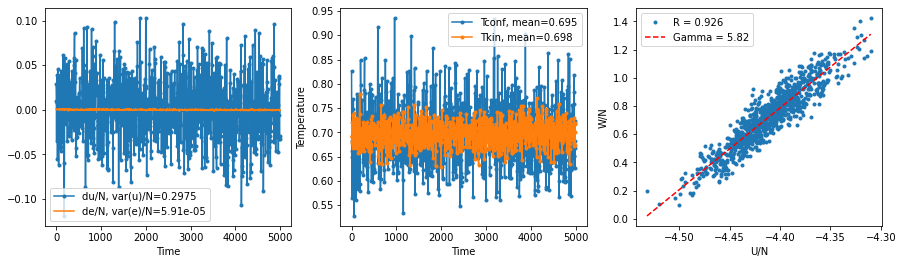

In [4]:
skins, timings, nblist_updates = benchmark(nx=4, ny=4, nz=4, pb=8, tp=32, skin=0.4, UtilizeNIII=False)

dt = 0.004999999888241291 = 9.999999776482582 fs
256 32
[[(4., -4., 2.5)]]
Generating interactions for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
Generating NVE integrator for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
Generating NVT integrator for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
[6.7183847 6.7183847 6.7183847] 0.8442000274938879 86.24381612267538
test_steps :  195312


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (32) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 58954.448, nbflag:[    0     0 52828]
1, 0.200, 95853.017, nbflag:[    0     0 28374]
2, 0.300, 88478.524, nbflag:[    0     0 19097]
3, 0.400, 93876.431, nbflag:[    0     0 14200]
4, 0.500, 85041.660, nbflag:[    0     0 11175]
5, 0.600, 85746.491, nbflag:[   0    0 9079]
6, 0.700, 86154.398, nbflag:[   0    0 7535]
7, 0.800, 88995.812, nbflag:[   0    0 6321]
8, 0.900, 84892.606, nbflag:[   0    0 5408]
9, 1.000, 85497.763, nbflag:[   0    0 4627]
10, 1.100, 81106.099, nbflag:[   0    0 3983]
11, 1.200, 84114.871, nbflag:[   0    0 3431]
12, 1.300, 78972.349, nbflag:[   0    0 2979]
13, 1.400, 72006.764, nbflag:[   0    0 2601]
optimal skin: 0.2
	steps : 1000000
	nbflag :  [     0      0 145340]
	time : 11.1705498046875 s
	time/steps : 11.1705498046875 us
	TPS :  89521.10840420493
	MATS :  22.917403751476463
	ns/day :  77346.23593240992
	ms/year :  28.231376115329624



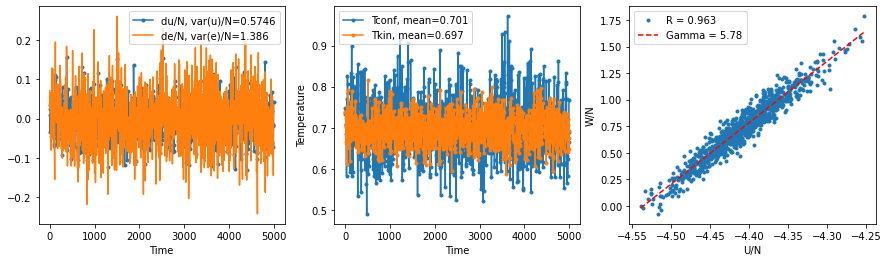

In [5]:
skins, timings, nblist_updates = benchmark(nx=4, ny=4, nz=4, pb=8, tp=32, skin=0.4, UtilizeNIII=False, integrator='NVT')

# N=512

dt = 0.005 = 10.0 fs
512 64
[[(4., -4., 2.5)]]
Generating interactions for 512 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:64
	Number (virtual) particles: 512
	Number of threads 16384
Generating NVE integrator for 512 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:64
	Number (virtual) particles: 512
	Number of threads 16384
[ 6.7183847  6.7183847 13.4367695] 0.8442000274938879 86.24381612267538
test_steps :  97656


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (64) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 41747.263, nbflag:[    0     0 27861]
1, 0.200, 79955.796, nbflag:[    0     0 14890]
2, 0.300, 81401.024, nbflag:[    0     0 10054]
3, 0.400, 81604.274, nbflag:[   0    0 7516]
4, 0.500, 79191.127, nbflag:[   0    0 5909]
5, 0.600, 75811.656, nbflag:[   0    0 4824]
6, 0.700, 75105.966, nbflag:[   0    0 4028]
7, 0.800, 73745.621, nbflag:[   0    0 3413]
8, 0.900, 69927.648, nbflag:[   0    0 2918]
9, 1.000, 73733.176, nbflag:[   0    0 2510]
10, 1.100, 72362.465, nbflag:[   0    0 2195]
11, 1.200, 71383.971, nbflag:[   0    0 1895]
12, 1.300, 68671.987, nbflag:[   0    0 1675]
13, 1.400, 65173.310, nbflag:[   0    0 1461]
optimal skin: 0.4
	steps : 1000000
	nbflag :  [    0     0 76747]
	time : 12.6031572265625 s
	time/steps : 12.6031572265625 us
	TPS :  79345.1975583065
	MATS :  40.62474114985293
	ns/day :  68554.25069037682
	ms/year :  25.022301501987542



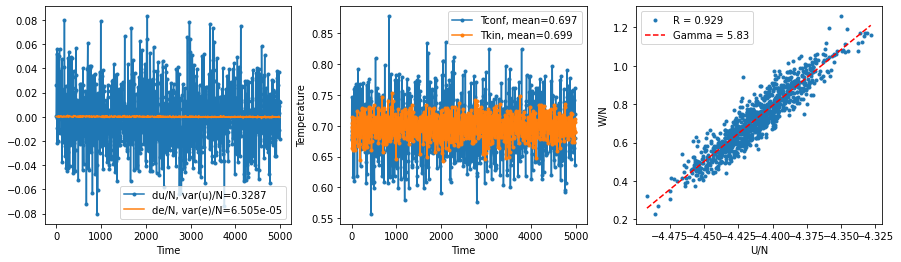

In [6]:
skins, timings, nblist_updates = benchmark(nx=4, ny=4, nz=8, pb=8, tp=32, skin=0.4, UtilizeNIII=False)

dt = 0.005 = 10.0 fs
512 64
[[(4., -4., 2.5)]]
Generating NVE integrator for 512 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:64
	Number (virtual) particles: 512
	Number of threads 8192
[ 6.7183847  6.7183847 13.4367695] 0.8442000274938879 86.24381612267538
test_steps :  97656


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (64) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 38909.343, nbflag:[    0     0 27902]
1, 0.200, 74447.397, nbflag:[    0     0 14920]
2, 0.300, 75795.035, nbflag:[    0     0 10059]
3, 0.400, 75740.520, nbflag:[   0    0 7510]
4, 0.500, 77030.078, nbflag:[   0    0 5906]
5, 0.600, 80007.572, nbflag:[   0    0 4834]
6, 0.700, 75413.636, nbflag:[   0    0 4024]
7, 0.800, 73691.894, nbflag:[   0    0 3399]
8, 0.900, 64936.859, nbflag:[   0    0 2914]
9, 1.000, 75588.117, nbflag:[   0    0 2510]
10, 1.100, 78651.566, nbflag:[   0    0 2192]
11, 1.200, 75310.192, nbflag:[   0    0 1898]
12, 1.300, 75795.459, nbflag:[   0    0 1663]
13, 1.400, 76214.663, nbflag:[   0    0 1461]
optimal skin: 0.6
	steps : 1000000
	nbflag :  [    0     0 49278]
	time : 13.072466796875 s
	time/steps : 13.072466796875 us
	TPS :  76496.65633413979
	MATS :  39.16628804307957
	ns/day :  66093.11107269677
	ms/year :  24.123985541534324



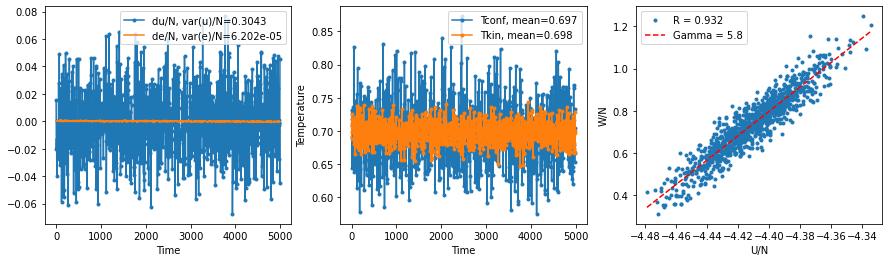

In [8]:
skins, timings, nblist_updates = benchmark(nx=4, ny=4, nz=8, pb=8, tp=16, skin=0.4)

# N=1024

dt = 0.005 = 10.0 fs
1024 128
[[(4., -4., 2.5)]]
Generating NVE integrator for 1024 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:128
	Number (virtual) particles: 1024
	Number of threads 16384
[ 6.7183847 13.4367695 13.4367695] 0.8442000274938879 95.47677376326357
test_steps :  48828
0, 0.100, 24342.901, nbflag:[    0     0 14963]
1, 0.200, 57009.650, nbflag:[   0    0 7771]
2, 0.300, 58277.719, nbflag:[   0    0 5256]
3, 0.400, 61392.681, nbflag:[   0    0 3922]
4, 0.500, 59212.054, nbflag:[   0    0 3098]
5, 0.600, 58778.897, nbflag:[   0    0 2547]
6, 0.700, 57840.503, nbflag:[   0    0 2129]
7, 0.800, 57506.658, nbflag:[   0    0 1816]
8, 0.900, 54339.012, nbflag:[   0    0 1562]
9, 1.000, 53871.230, nbflag:[   0    0 1351]
10, 1.100, 52767.814, nbflag:[   0    0 1184]
11, 1.200, 51003.922, nbflag:[   0    0 1034]
12, 1.300, 49354.165, nbflag:[  0   0 918]
13, 1.400, 47746.885, nbflag:[  0   0 807]
optimal skin: 0.4
	steps : 1000000
	nbflag :  [    0     0 80450]
	time : 16.

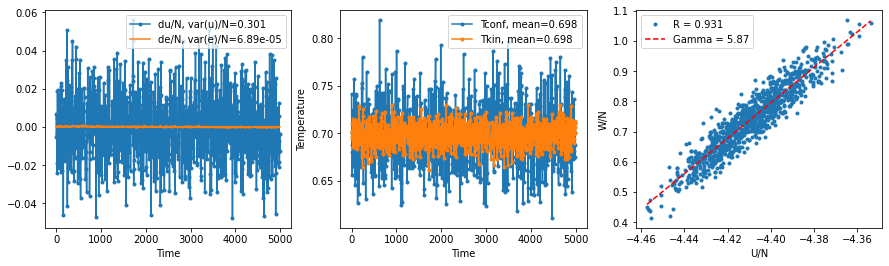

In [9]:
skins, timings, nblist_updates = benchmark(nx=4, ny=8, nz=8, pb=8, tp=16, skin=0.5, UtilizeNIII=False)

dt = 0.005 = 10.0 fs
1024 128
[[(4., -4., 2.5)]]
Generating NVE integrator for 1024 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:128
	Number (virtual) particles: 1024
	Number of threads 16384
[ 6.7183847 13.4367695 13.4367695] 0.8442000274938879 95.47677376326357
test_steps :  48828
0, 0.100, 22726.868, nbflag:[    0     0 14926]
1, 0.200, 47760.490, nbflag:[   0    0 7785]
2, 0.300, 49014.710, nbflag:[   0    0 5267]
3, 0.400, 51047.543, nbflag:[   0    0 3935]
4, 0.500, 50011.518, nbflag:[   0    0 3110]
5, 0.600, 50259.235, nbflag:[   0    0 2551]
6, 0.700, 51046.035, nbflag:[   0    0 2124]
7, 0.800, 53305.489, nbflag:[   0    0 1810]
8, 0.900, 49428.054, nbflag:[   0    0 1565]
9, 1.000, 53470.220, nbflag:[   0    0 1359]
10, 1.100, 55830.842, nbflag:[   0    0 1178]
11, 1.200, 49370.195, nbflag:[   0    0 1036]
12, 1.300, 54959.043, nbflag:[  0   0 914]
13, 1.400, 54369.128, nbflag:[  0   0 806]
optimal skin: 1.0999999999999999
	steps : 1000000
	nbflag :  [    0     0 241

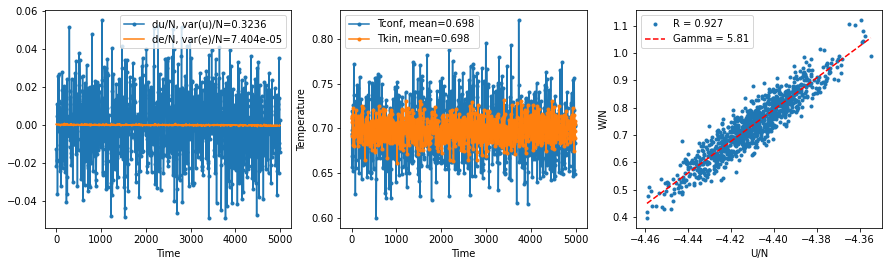

In [10]:
skins, timings, nblist_updates = benchmark(nx=4, ny=8, nz=8, pb=8, tp=16, skin=0.5)

# N=2048

dt = 0.005 = 10.0 fs
2048 128
[[(4., -4., 2.5)]]
Generating NVE integrator for 2048 particles in 3 dimensions:
	pb: 16, tp:8, num_blocks:128
	Number (virtual) particles: 2048
	Number of threads 16384
[13.4367695 13.4367695 13.4367695] 0.8442000274938879 95.47677376326357
test_steps :  24414
0, 0.100, 10725.753, nbflag:[   0    0 7924]
1, 0.200, 30534.308, nbflag:[   0    0 4055]
2, 0.300, 33058.253, nbflag:[   0    0 2736]
3, 0.400, 35446.180, nbflag:[   0    0 2048]
4, 0.500, 34995.551, nbflag:[   0    0 1625]
5, 0.600, 34796.438, nbflag:[   0    0 1335]
6, 0.700, 35722.752, nbflag:[   0    0 1120]
7, 0.800, 36444.012, nbflag:[  0   0 958]
8, 0.900, 35229.716, nbflag:[  0   0 824]
9, 1.000, 34905.965, nbflag:[  0   0 721]
10, 1.100, 34568.475, nbflag:[  0   0 633]
11, 1.200, 34063.185, nbflag:[  0   0 556]
12, 1.300, 32519.261, nbflag:[  0   0 497]
13, 1.400, 31621.655, nbflag:[  0   0 442]
optimal skin: 0.7999999999999999
	steps : 1000000
	nbflag :  [    0     0 39101]
	time : 27.951

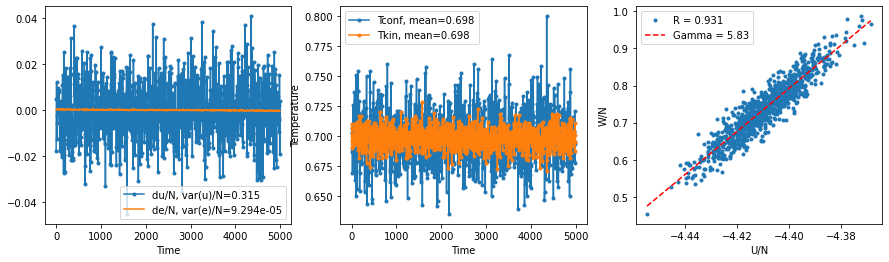

In [11]:
skins, timings, nblist_updates = benchmark(nx=8, ny=8, nz=8, pb=16, tp=8, skin=0.5)

# N=4096

dt = 0.005 = 10.0 fs
4096 256
[[(4., -4., 2.5)]]
Generating NVE integrator for 4096 particles in 3 dimensions:
	pb: 16, tp:4, num_blocks:256
	Number (virtual) particles: 4096
	Number of threads 16384
[13.4367695 13.4367695 26.873539 ] 0.8442000274938879 105.34624322894021
test_steps :  12207
0, 0.100, 5035.534, nbflag:[   0    0 4059]
1, 0.200, 12751.187, nbflag:[   0    0 2088]
2, 0.300, 15281.021, nbflag:[   0    0 1422]
3, 0.400, 16866.495, nbflag:[   0    0 1068]
4, 0.500, 17813.595, nbflag:[  0   0 848]
5, 0.600, 18309.956, nbflag:[  0   0 697]
6, 0.700, 18566.526, nbflag:[  0   0 589]
7, 0.800, 18437.252, nbflag:[  0   0 504]
8, 0.900, 18533.097, nbflag:[  0   0 437]
9, 1.000, 18206.501, nbflag:[  0   0 382]
10, 1.100, 17858.642, nbflag:[  0   0 335]
11, 1.200, 17294.272, nbflag:[  0   0 296]
12, 1.300, 16614.130, nbflag:[  0   0 268]
13, 1.400, 16025.677, nbflag:[  0   0 236]
optimal skin: 0.7
	steps : 1000000
	nbflag :  [    0     0 47927]
	time : 53.198921875 s
	time/steps : 5

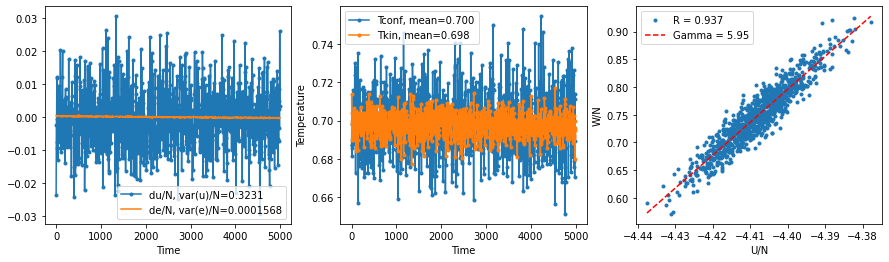

In [32]:
skins, timings, nblist_updates = benchmark(nx=8, ny=8, nz=16, pb=16, tp=4, skin=0.6)

dt = 0.004999999888241291 = 9.999999776482582 fs
4096 256
[[(4., -4., 2.5)]]
Generating interactions for 4096 particles in 3 dimensions:
	pb: 16, tp:4, num_blocks:256
	Number (virtual) particles: 4096
	Number of threads 16384
Generating NVE integrator for 4096 particles in 3 dimensions:
	pb: 16, tp:4, num_blocks:256
	Number (virtual) particles: 4096
	Number of threads 16384
Generating NVT integrator for 4096 particles in 3 dimensions:
	pb: 16, tp:4, num_blocks:256
	Number (virtual) particles: 4096
	Number of threads 16384
[13.4367695 13.4367695 26.873539 ] 0.8442000274938879 105.34624322894021
test_steps :  12207
0, 0.100, 4878.206, nbflag:[   0    0 4057]
1, 0.200, 12164.058, nbflag:[   0    0 2090]
2, 0.300, 14323.736, nbflag:[   0    0 1420]
3, 0.400, 15595.786, nbflag:[   0    0 1067]
4, 0.500, 16461.511, nbflag:[  0   0 853]
5, 0.600, 16883.654, nbflag:[  0   0 697]
6, 0.700, 17150.685, nbflag:[  0   0 589]
7, 0.800, 17104.353, nbflag:[  0   0 504]
8, 0.900, 16916.156, nbflag:[  0

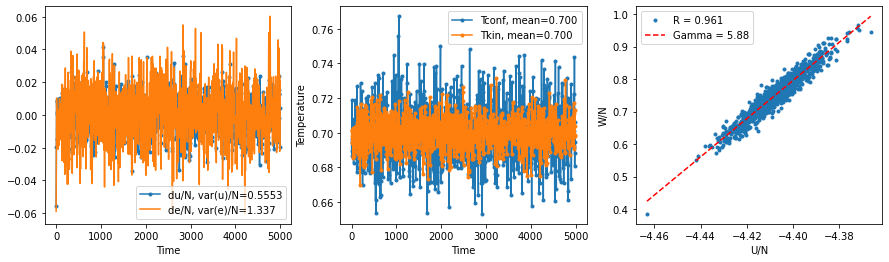

In [15]:
skins, timings, nblist_updates = benchmark(nx=8, ny=8, nz=16, pb=16, tp=4, skin=0.6, integrator='NVT')

# N=8192

dt = 0.005 = 10.0 fs
8192 256
[[(4., -4., 2.5)]]
Generating NVE integrator for 8192 particles in 3 dimensions:
	pb: 32, tp:2, num_blocks:256
	Number (virtual) particles: 8192
	Number of threads 16384
[13.4367695 26.873539  26.873539 ] 0.8442000274938879 138.9858931848634
test_steps :  6103
0, 0.100, 1859.716, nbflag:[   0    0 2036]
1, 0.200, 4273.214, nbflag:[   0    0 1069]
2, 0.300, 5439.625, nbflag:[  0   0 737]
3, 0.400, 6356.551, nbflag:[  0   0 555]
4, 0.500, 6992.519, nbflag:[  0   0 441]
5, 0.600, 7441.221, nbflag:[  0   0 362]
6, 0.700, 7653.821, nbflag:[  0   0 308]
7, 0.800, 7732.109, nbflag:[  0   0 263]
8, 0.900, 7762.894, nbflag:[  0   0 229]
9, 1.000, 7733.689, nbflag:[  0   0 199]
10, 1.100, 7644.807, nbflag:[  0   0 178]
11, 1.200, 7428.267, nbflag:[  0   0 159]
12, 1.300, 7120.419, nbflag:[  0   0 144]
13, 1.400, 6927.835, nbflag:[  0   0 127]
optimal skin: 0.8999999999999999
	steps : 1000000
	nbflag :  [    0     0 37222]
	time : 122.3496953125 s
	time/steps : 122.3

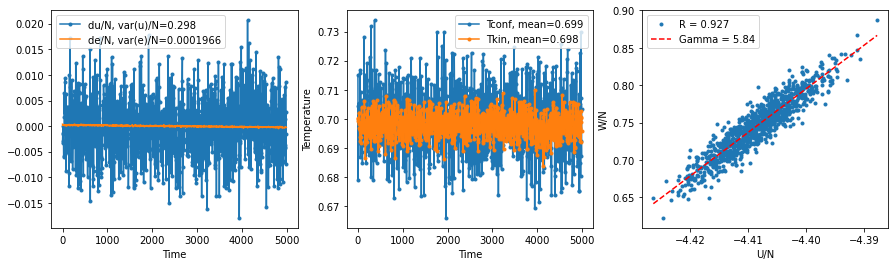

In [33]:
skins, timings, nblist_updates = benchmark(nx=8, ny=16, nz=16, pb=32, tp=2, skin=0.9)

dt = 0.005 = 10.0 fs
8192 256
[[(4., -4., 2.5)]]
Generating NVE integrator for 8192 particles in 3 dimensions:
	pb: 32, tp:2, num_blocks:256
	Number (virtual) particles: 8192
	Number of threads 16384
[13.4367695 26.873539  26.873539 ] 0.8442000274938879 138.9858931848634
test_steps :  6103
0, 0.100, 1405.778, nbflag:[   0    0 2036]
1, 0.200, 3085.252, nbflag:[   0    0 1072]
2, 0.300, 4007.972, nbflag:[  0   0 736]
3, 0.400, 4722.720, nbflag:[  0   0 555]
4, 0.500, 5191.826, nbflag:[  0   0 446]
5, 0.600, 5554.692, nbflag:[  0   0 362]
6, 0.700, 5721.035, nbflag:[  0   0 308]
7, 0.800, 5847.151, nbflag:[  0   0 262]
8, 0.900, 5868.477, nbflag:[  0   0 229]
9, 1.000, 5860.304, nbflag:[  0   0 200]
10, 1.100, 5764.064, nbflag:[  0   0 178]
11, 1.200, 5628.795, nbflag:[  0   0 157]
12, 1.300, 5431.460, nbflag:[  0   0 144]
13, 1.400, 5237.932, nbflag:[  0   0 128]
optimal skin: 0.8999999999999999
	steps : 1000000
	nbflag :  [    0     0 37226]
	time : 177.7778125 s
	time/steps : 177.7778

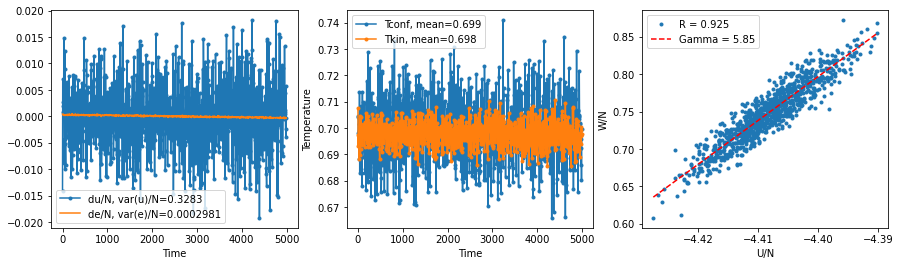

In [34]:
skins, timings, nblist_updates = benchmark(nx=8, ny=16, nz=16, pb=32, tp=2, skin=0.9, UtilizeNIII=False)

dt = 0.005 = 10.0 fs
8192 128
[[(4., -4., 2.5)]]
Generating NVE integrator for 8192 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:128
	Number (virtual) particles: 8192
	Number of threads 16384
[13.4367695 26.873539  26.873539 ] 0.8442000274938879 138.9858931848634
test_steps :  6103
0, 0.100, 1812.066, nbflag:[   0    0 2036]
1, 0.200, 4253.674, nbflag:[   0    0 1081]
2, 0.300, 5430.285, nbflag:[  0   0 736]
3, 0.400, 6339.299, nbflag:[  0   0 556]
4, 0.500, 6970.540, nbflag:[  0   0 441]
5, 0.600, 7381.340, nbflag:[  0   0 364]
6, 0.700, 7656.285, nbflag:[  0   0 306]
7, 0.800, 7744.038, nbflag:[  0   0 263]
8, 0.900, 7704.466, nbflag:[  0   0 230]
9, 1.000, 7647.757, nbflag:[  0   0 203]
10, 1.100, 7679.669, nbflag:[  0   0 177]
11, 1.200, 7465.989, nbflag:[  0   0 157]
12, 1.300, 7233.933, nbflag:[  0   0 143]
13, 1.400, 6989.974, nbflag:[  0   0 128]
optimal skin: 0.7999999999999999
	steps : 1000000
	nbflag :  [    0     0 42826]
	time : 123.598734375 s
	time/steps : 123.59

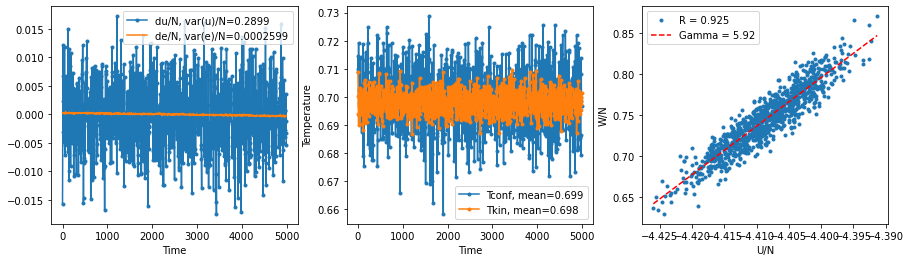

In [35]:
skins, timings, nblist_updates = benchmark(nx=8, ny=16, nz=16, pb=64, tp=2, skin=0.9)

# N=16384

dt = 0.004999999888241291 = 9.999999776482582 fs
16384 256
[[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
[26.873539 26.873539 26.873539] 0.8442000274938879 151.61358055925652
test_steps :  3051
0, 0.100, 609.340, nbflag:[   0    0 1019]
1, 0.200, 1275.479, nbflag:[  0   0 559]
2, 0.300, 1719.487, nbflag:[  0   0 381]
3, 0.400, 2092.550, nbflag:[  0   0 288]
4, 0.500, 2403.425, nbflag:[  0   0 230]
5, 0.600, 2661.620, nbflag:[  0   0 189]
6, 0.700, 2858.629, nbflag:[  0   0 160]
7, 0.800, 2991.444, nbflag:[  0   0 138]
8, 0.900, 3117.862, nbflag:[  0   0 120]
9, 1.

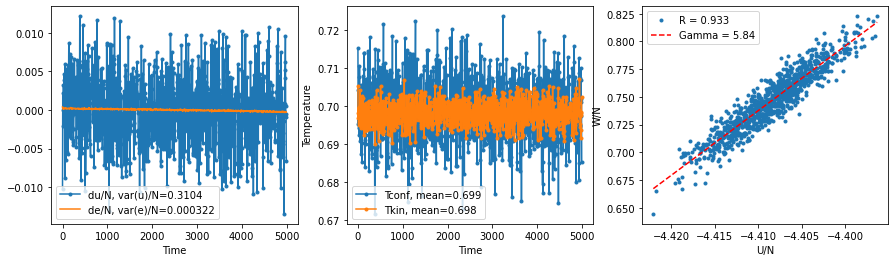

In [19]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=1, skin=1.0, gridsync=True, UtilizeNIII=True)

dt = 0.004999999888241291 = 9.999999776482582 fs
16384 256
[[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
[26.873539 26.873539 26.873539] 0.8442000274938879 151.61358055925652
test_steps :  3051
0, 0.100, 535.534, nbflag:[   0    0 1020]
1, 0.200, 1233.003, nbflag:[  0   0 555]
2, 0.300, 1640.278, nbflag:[  0   0 383]
3, 0.400, 1983.042, nbflag:[  0   0 288]
4, 0.500, 2275.806, nbflag:[  0   0 229]
5, 0.600, 2496.070, nbflag:[  0   0 191]
6, 0.700, 2670.616, nbflag:[  0   0 161]
7, 0.800, 2806.140, nbflag:[  0   0 137]
8, 0.900, 2922.678, nbflag:[  0   0 119]
9, 1.

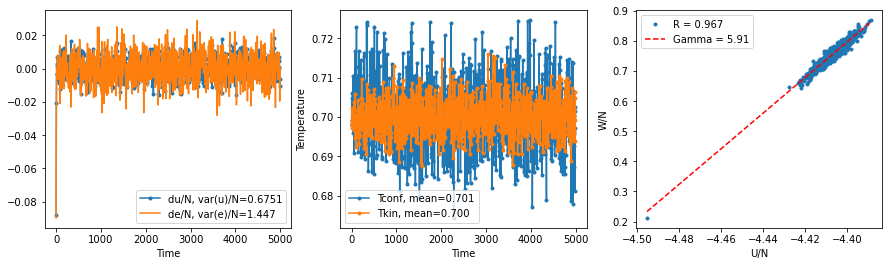

In [21]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=1, skin=1.0, gridsync=True, UtilizeNIII=True, integrator='NVT')

dt = 0.005 = 10.0 fs
16384 256
[[(4., -4., 2.5)]]
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
[26.873539 26.873539 26.873539] 0.8442000274938879 151.61358055925652
test_steps :  3051
0, 0.100, 426.134, nbflag:[   0    0 1020]
1, 0.200, 847.672, nbflag:[  0   0 556]
2, 0.300, 1167.158, nbflag:[  0   0 382]
3, 0.400, 1447.039, nbflag:[  0   0 286]
4, 0.500, 1655.989, nbflag:[  0   0 228]
5, 0.600, 1844.089, nbflag:[  0   0 189]
6, 0.700, 2003.432, nbflag:[  0   0 159]
7, 0.800, 2128.887, nbflag:[  0   0 137]
8, 0.900, 2206.676, nbflag:[  0   0 120]
9, 1.000, 2270.790, nbflag:[  0   0 105]
10, 1.100, 2278.757, nbflag:[ 0  0 94]
11, 1.200, 2291.572, nbflag:[ 0  0 83]
12, 1.300, 2273.337, nbflag:[ 0  0 74]
13, 1.400, 2215.680, nbflag:[ 0  0 67]
optimal skin: 1.2
	steps : 1000000
	nbflag :  [    0     0 27014]
	time : 473.43171875 s
	time/steps : 473.43171875 us
	TPS :  2112.237014115

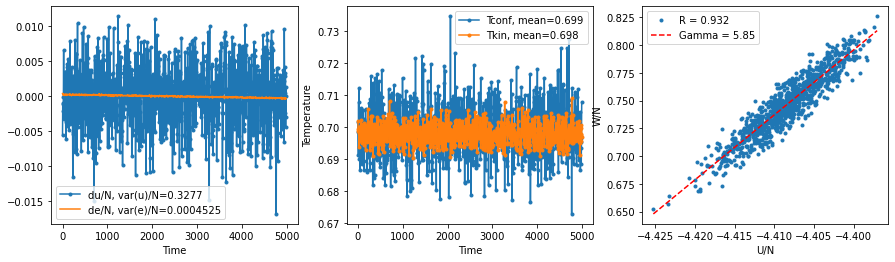

In [37]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=1, skin=1.0, gridsync=True, UtilizeNIII=False)

dt = 0.004999999888241291 = 9.999999776482582 fs
16384 256
[[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
[26.873539 26.873539 26.873539] 0.8442000274938879 151.61358055925652
test_steps :  3051
0, 0.100, 724.630, nbflag:[   0    0 1019]
1, 0.200, 1633.274, nbflag:[  0   0 564]
2, 0.300, 2202.581, nbflag:[  0   0 385]
3, 0.400, 2693.412, nbflag:[  0   0 289]
4, 0.500, 3141.893, nbflag:[  0   0 228]
5, 0.600, 3386.290, nbflag:[  0   0 191]
6, 0.700, 3363.466, nbflag:[  0   0 162]
7, 0.800, 3374.833, nbflag:[  0   0 140]
8, 0.900, 3355.272, nbflag:[  0   0 121]
9, 1.

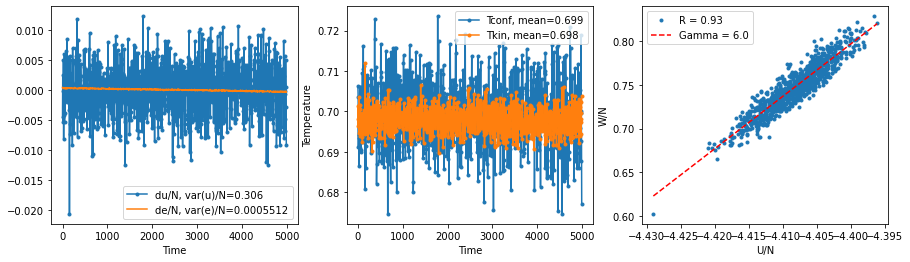

In [6]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=2, skin=1.0, gridsync=False, UtilizeNIII=True)

dt = 0.004999999888241291 = 9.999999776482582 fs
16384 256
[[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
[26.873539 26.873539 26.873539] 0.8442000274938879 151.61358055925652
test_steps :  3051


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 662.889, nbflag:[   0    0 1023]
1, 0.200, 1489.321, nbflag:[  0   0 556]
2, 0.300, 1904.173, nbflag:[  0   0 383]
3, 0.400, 1845.002, nbflag:[  0   0 287]
4, 0.500, 1829.937, nbflag:[  0   0 229]
5, 0.600, 1865.072, nbflag:[  0   0 190]
6, 0.700, 1866.161, nbflag:[  0   0 159]
7, 0.800, 1886.734, nbflag:[  0   0 137]
8, 0.900, 1827.251, nbflag:[  0   0 119]
9, 1.000, 1852.656, nbflag:[  0   0 104]
10, 1.100, 1868.073, nbflag:[ 0  0 92]
11, 1.200, 1831.487, nbflag:[ 0  0 83]
12, 1.300, 1886.927, nbflag:[ 0  0 75]
13, 1.400, 1851.203, nbflag:[ 0  0 66]
optimal skin: 0.3
	steps : 1000000
	nbflag :  [     0      0 124424]
	time : 558.8186875 s
	time/steps : 558.8186875 us
	TPS :  1789.4891891925142
	MATS :  29.318990875730154
	ns/day :  1546.1186249038872
	ms/year :  0.5643332980899188



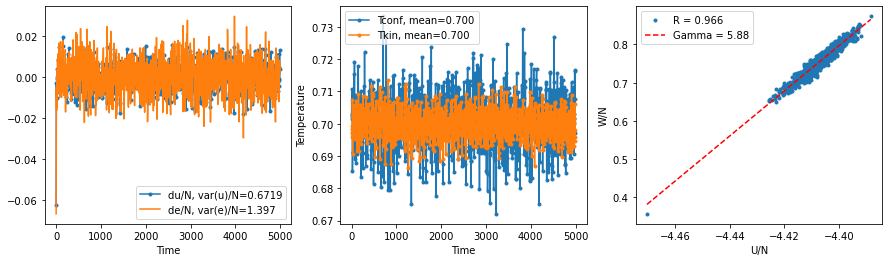

In [7]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=2, skin=1.0, gridsync=False, UtilizeNIII=True, integrator='NVT')

dt = 0.004999999888241291 = 9.999999776482582 fs
16384 256
[[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
[26.873539 26.873539 26.873539] 0.8442000274938879 151.61358055925652
test_steps :  3051
0, 0.100, 557.869, nbflag:[   0    0 1020]
1, 0.200, 1135.087, nbflag:[  0   0 561]
2, 0.300, 1574.274, nbflag:[  0   0 382]
3, 0.400, 1958.376, nbflag:[  0   0 288]
4, 0.500, 2303.096, nbflag:[  0   0 229]
5, 0.600, 2563.748, nbflag:[  0   0 190]
6, 0.700, 2783.455, nbflag:[  0   0 160]
7, 0.800, 2942.027, nbflag:[  0   0 138]
8, 0.900, 3062.792, nbflag:[  0   0 120]
9, 1.

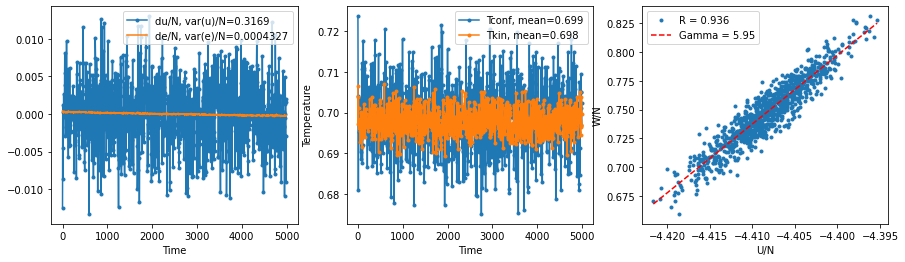

In [17]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=2, skin=1.0, gridsync=False, UtilizeNIII=False)

# N=32768

dt = 0.005 = 10.0 fs
32768 256
[[(4., -4., 2.5)]]
Generating interactions for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
Generating NVE integrator for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
[26.873539 26.873539 53.747078] 0.8442000274938879 151.61358055925652
test_steps :  1525
0, 0.100, 211.729, nbflag:[  0   0 513]
1, 0.200, 413.589, nbflag:[  0   0 296]
2, 0.300, 589.672, nbflag:[  0   0 198]
3, 0.400, 738.896, nbflag:[  0   0 150]
4, 0.500, 876.068, nbflag:[  0   0 120]
5, 0.600, 999.271, nbflag:[ 0  0 99]
6, 0.700, 1103.569, nbflag:[ 0  0 83]
7, 0.800, 1186.445, nbflag:[ 0  0 73]
8, 0.900, 1258.475, nbflag:[ 0  0 63]
9, 1.000, 1331.335, nbflag:[ 0  0 56]
10, 1.100, 1354.443, nbflag:[ 0  0 49]
11, 1.200, 1383.978, nbflag:[ 0  0 44]
12, 1.300, 1427.440, nbflag:[ 0  0 40]
13, 1.400, 1450.152, nbflag:[ 0  0 35]
optimal sk

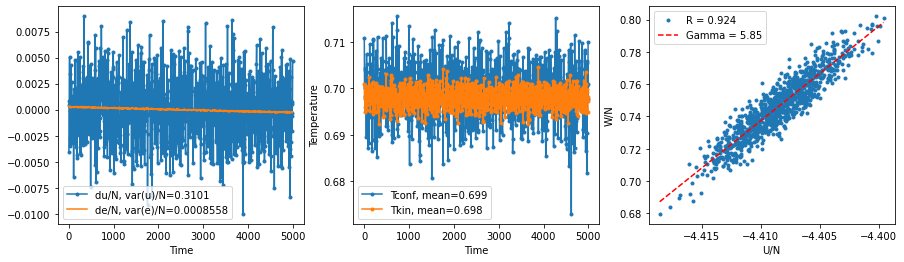

In [6]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=32, pb=128, tp=1, skin=1.0, gridsync=False)

dt = 0.004999999888241291 = 9.999999776482582 fs
32768 256
[[(4., -4., 2.5)]]
Generating interactions for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
Generating NVE integrator for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
Generating NVT integrator for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
[26.873539 26.873539 53.747078] 0.8442000274938879 151.61358055925652
test_steps :  1525


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 210.526, nbflag:[  0   0 517]
1, 0.200, 411.117, nbflag:[  0   0 292]
2, 0.300, 569.469, nbflag:[  0   0 200]
3, 0.400, 720.092, nbflag:[  0   0 149]
4, 0.500, 847.724, nbflag:[  0   0 119]
5, 0.600, 958.402, nbflag:[ 0  0 98]
6, 0.700, 1044.919, nbflag:[ 0  0 84]
7, 0.800, 1122.228, nbflag:[ 0  0 72]
8, 0.900, 1210.792, nbflag:[ 0  0 63]
9, 1.000, 1263.204, nbflag:[ 0  0 55]
10, 1.100, 1277.810, nbflag:[ 0  0 50]
11, 1.200, 1352.380, nbflag:[ 0  0 43]
12, 1.300, 1354.684, nbflag:[ 0  0 39]
13, 1.400, 1355.139, nbflag:[ 0  0 36]
optimal skin: 1.4
	steps : 1000000
	nbflag :  [    0     0 22944]
	time : 997.5955 s
	time/steps : 997.5955 us
	TPS :  1002.4102955556635
	MATS :  32.84698056476798
	ns/day :  866.082476001641
	ms/year :  0.31612010374059896



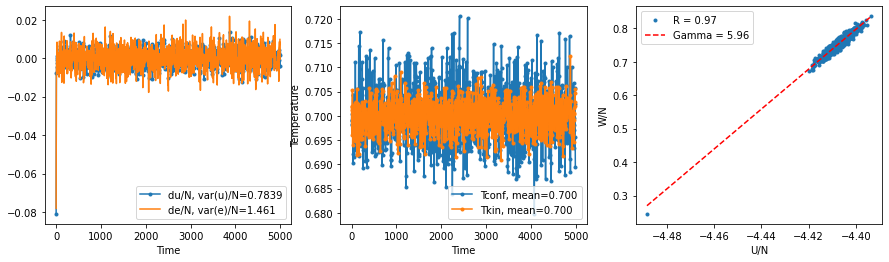

In [18]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=32, pb=128, tp=1, skin=1.0, gridsync=False, UtilizeNIII=True, integrator='NVT')

# Benchmarks

In [25]:

Ns = np.array([512, 1024, 2048, 4096, 8192, 16384, 32768])
TPS_rumd_1080 = np.array([35354, 34226, 31454, 17508, 8824, 6617, 3075])
TPS_rumdpy_3070lap_11 = np.array([80549, 63196, 37959, 17010, 6495, 3441, 872])
TPS_rumdpy_3070lap_12 = np.array([72585, 57683, 37063, 20163, 9180, 3341, 1174])
TPS_rumdpy_3070lap_15 = np.array([80607, 63118, 36931, 20413, 9365, 3365, 1179])
TPS_rumdpy_3070lap_19 = np.array([80789, 63171, 37593, 21635, 9431, 3241, 1165])
TPS_rumdpy_3070lap_25 = np.array([82198, 58611, 34459, 19226, 8300, 3387, 1086])
TPS_rumdpy_3070lap_27 = np.array([81754, 58291, 34427, 18839, 8208, 3462, 1103])
TPS_rumdpy_3070lap_28 = np.array([82215, 60171, 35793, 18839, 8208, 3462, 1103])


print(f'Speed-up: {(TPS_rumdpy_3070lap_27/TPS_rumdpy_3070lap_11)}')

Speed-up: [1.01495984 0.92238433 0.90695224 1.10752499 1.26374134 1.00610288
 1.26490826]


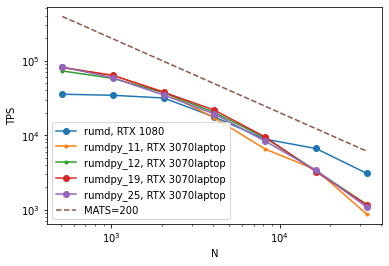

In [23]:
### plt.figure(figsize=(12,8))
plt.loglog(Ns, TPS_rumd_1080, 'o-', label='rumd, RTX 1080')
plt.loglog(Ns, TPS_rumdpy_3070lap_11, '.-', label='rumdpy_11, RTX 3070laptop')
plt.loglog(Ns, TPS_rumdpy_3070lap_12, '.-', label='rumdpy_12, RTX 3070laptop')
plt.loglog(Ns, TPS_rumdpy_3070lap_19, 'o-', label='rumdpy_19, RTX 3070laptop')
plt.loglog(Ns, TPS_rumdpy_3070lap_25, 'o-', label='rumdpy_25, RTX 3070laptop')
plt.loglog(Ns, 200*1e6/Ns, '--', label='MATS=200')
plt.legend()
plt.xlabel('N')
plt.ylabel('TPS')
plt.show()